# Fraud Detection Model

K-means clustering will be used to predict which transactions are fraudulent. Fraudulent transactions will most likely have similar features/behavior with one another, therefore they will all be in the same cluster. We can then treat the cluster with the highest fraud probability as the cluster with all fraudulent transactions.

## Data Processing for K-Means Clustering

In [52]:
# Importing pyspark libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import mean, countDistinct
from pyspark.sql.types import IntegerType

# Importing model libraries
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler)
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Importing pandas libaries
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

In [13]:
# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

## Loading Data

In [14]:
#Read data
sdf = spark.read.parquet("../data/curated/part-00013-47f00a8c-554d-4703-b168-5eb79335c6d7-c000.snappy.parquet")

Only consider instances with non-null fraud probabilities. It is assumed that users and merchants with no fraud probabilities are deemed to be not suspicious, therefore the probability of their transactions being fraudulent will be 0.

In [15]:
# separate instances with null fraud probabilities
sdf_fraudless = sdf.filter(F.col("merchant_fraud_probability").isNull() | F.col("user_fraud_probability").isNull())
sdf_fraud = sdf.filter(F.col("merchant_fraud_probability").isNotNull() & F.col("user_fraud_probability").isNotNull())
sdf = sdf_fraud

Select attributes.

In [16]:
# Selecting attributes
sdf = sdf.withColumn('postcode', sdf["postcode"].cast(IntegerType()))
features = ['merchant_abn', 'consumer_id', 'dollar_value', 'postcode', 'gender', 'revenue', 'rate', 'category']

Convert categorical features to integer and then one hot encode.

In [17]:
# Discretisation
stringToNum = StringIndexer(inputCol= 'gender', outputCol= 'genderNum')
output_data = stringToNum.fit(sdf).transform(sdf)

stringToNum = StringIndexer(inputCol= 'revenue', outputCol= 'revenueNum')
output_data = stringToNum.fit(output_data).transform(output_data)

stringToNum = StringIndexer(inputCol= 'category', outputCol= 'categoryNum')
output_data = stringToNum.fit(output_data).transform(output_data)

In [18]:
# One hot encoding
encoder = OneHotEncoder(inputCol= 'genderNum', outputCol = 'genderVec')
onehotdata = encoder.fit(output_data).transform(output_data)

encoder = OneHotEncoder(inputCol= 'revenueNum', outputCol = 'revenueVec')
onehotdata = encoder.fit(onehotdata).transform(onehotdata)

encoder = OneHotEncoder(inputCol= 'categoryNum', outputCol = 'categoryVec')
onehotdata = encoder.fit(onehotdata).transform(onehotdata)

Convert features to a single vector and standardize.

In [19]:
# Converting to vector
assembler1 = VectorAssembler(
inputCols= ['merchant_abn', 'consumer_id', 'dollar_value', 'postcode', 'genderVec', 'revenueVec', 'rate', 'categoryVec'],
outputCol='features')
result = assembler1.transform(onehotdata)

In [20]:
# standardizing the feature vector
scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(result)
data_scale_output = data_scale.transform(result)

## K-means Clustering Model

In [56]:
cost = np.zeros(11)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for k in range(2,11):
    KMeans_algo=KMeans(featuresCol='standardized', k= k)
    model = KMeans_algo.fit(data_scale_output)
    predictions = model.transform(data_scale_output)
    cost[k] = evaluator.evaluate(predictions)

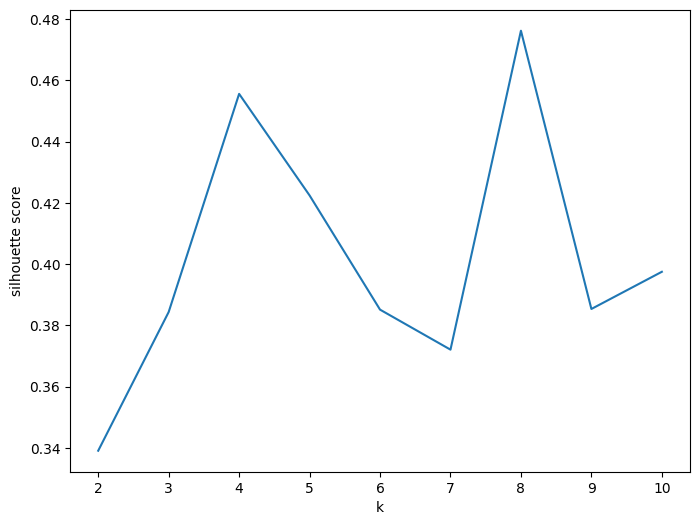

In [57]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),cost[2:])
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [58]:
# Build K-means clustering model
KMeans_algo=KMeans(featuresCol='standardized', k= 8)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)  
score=evaluator.evaluate(output)
score

0.476168901374045

In [59]:
# calculate mean merchant fraud probability for each cluster
output.groupBy("prediction").mean("merchant_fraud_probability").sort('prediction')

prediction,avg(merchant_fraud_probability)
0,0.3044391867511151
1,0.29193851871014215
2,0.31413304468559045
3,0.3013877398715409
4,0.6900000000000002
5,0.3097768762677496
6,0.30329451857138484
7,0.3113899762488364


In [60]:
# calculate mean user fraud probability for each cluster
output.groupBy("prediction").mean("user_fraud_probability").sort('prediction')

prediction,avg(user_fraud_probability)
0,0.1564263009958172
1,0.15256456320235984
2,0.15405497982742894
3,0.15268333117514762
4,0.1456025167642815
5,0.1471524786910183
6,0.14650068890094464
7,0.15558558679573395


In [61]:
output.groupBy("prediction").sum("dollar_value").sort('prediction')

prediction,sum(dollar_value)
0,647716.0800000009
1,911192.530000002
2,1051466.9299999992
3,1267981.6699999995
4,769.6700000000001
5,274112.4400000002
6,639605.9799999993
7,1685782.8299999982


In [62]:
output.select(mean('user_fraud_probability'), mean('merchant_fraud_probability'))

avg(user_fraud_probability),avg(merchant_fraud_probability)
0.1528190899405363,0.30229813253315363


Since cluster 0 has higher mean merchant and user fraud probabilities, we will treat all the transactions in this cluster as fraud. These transactions will not be included in the ranking system.

## Removal of Fraud Transactions

In [24]:
# count number of fraud transactions
output.filter(F.col("prediction") == 0).count()

4717

In total, 206014 transactions will be removed.

In [25]:
# ensure that each transaction has a unique order_id which will be used for joining
print(sdf.select(countDistinct("order_id")))
print(sdf.count())

+------------------------+
|count(DISTINCT order_id)|
+------------------------+
|                   17970|
+------------------------+

17970


In [26]:
# only join transactions from cluster 1
sdf = sdf.join(output.filter(F.col("prediction") == 1), on=["order_id"], how="leftSemi")
sdf.count()

3869

In [27]:
# combine the two dataframes
sdf = sdf.union(sdf_fraudless)
sdf.count()

515215

In [28]:
# save data for ranking
sdf.write.mode('overwrite').parquet('../data/curated/fraudless_data.parquet')